<a href="https://colab.research.google.com/github/nishantgovil03/LJMUResearch/blob/main/LSTM_AdamOptimizer_GloVeEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The source code for text Summarization using LSTM but using GloVe Embeddings



In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-02-05 01:18:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-05 01:18:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-05 01:18:48--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [1]:
import os
import pathlib

In [2]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM 
from tensorflow.keras.layers import  Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/

/content/drive/MyDrive


In [5]:
#path_to_glove_file = os.path.join(
#    os.path.expanduser("~"), "./glove.6B.100d.txt"
#)
path_to_glove_file = "glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Import the required libraries

Get data

In [6]:
data = pd.read_csv("InputData.csv")

Data Pre-processing 

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4450 entries, 0 to 4449
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Unnamed: 0                   4450 non-null   int64 
 1   Articles without stop words  4450 non-null   object
 2   Article with stop words      4450 non-null   object
 3   Summary                      4450 non-null   object
dtypes: int64(1), object(3)
memory usage: 139.2+ KB


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
stop_words=set(stopwords.words('english'))

Data Cleaner

In [10]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [11]:
#call the function
cleaned_text = []
for t in data['Article with stop words']:
    cleaned_text.append(text_cleaner(t,0))

In [ ]:
cleaned_text[:5]

['budget set scene electiongordon brown seek put economy centre labour bid third term power delivers ninth budget expected stress importance continued economic low unemployment interest chancellor expected freeze petrol duty raise stamp duty threshold conservatives lib dems insist voters face higher taxes officials said mr brown thought increase stamp duty threshold freeze petrol duty extension tax credit scheme poorer families possible help pensioners stamp duty threshold rise intended help first time buyers likely theme three main general election ten years buyers much greater chance avoiding stamp close half million england wales selling less since average uk property prices doubled starting threshold stamp duty tax credits number properties incurring stamp duty rocketed government tax liberal democrats unveiled proposals raise stamp duty threshold tories also thought likely propose increased shadow chancellor oliver letwin branding stamp duty classic labour stealth tories say whate

In [14]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [15]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [16]:
cleaned_summary[:10]

['increase in the stamp duty threshold from freeze on petrol duty an extension of tax credit scheme for poorer families possible help for pensioners the stamp duty threshold rise is intended to help first time buyers likely theme of all three of the main general election chancellor is expected to freeze petrol duty and raise the stamp duty threshold from tories are also thought likely to propose increased with shadow chancellor oliver letwin branding stamp duty classic labour stealth credits as the number of properties incurring stamp duty has rocketed as has the government tax average uk property prices have more than doubled while the starting threshold for stamp duty has not the lib dems david laws the chancellor will no doubt tell us today how wonderfully the economy is he liberal democrats unveiled their own proposals to raise the stamp duty threshold to in labour is elected there will be very substantial tax increase in the budget after the of the order of around',
 'they are ver

Visualization

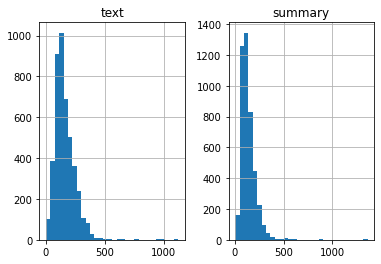

In [17]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [18]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=200):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.8489887640449438


In [19]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=300):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9397752808988764


In [20]:
max_text_len=300
max_summary_len=200

In [21]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

Adding START and END Tokens to the Summary 

In [22]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [23]:
pd.set_option("display.max_colwidth", 1500)

Test Train Split 

In [24]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [25]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

Rare words 

In [26]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 43.38055920435354
Total Coverage of rare words: 3.811186050828616


In [27]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [31]:
word_index = x_tokenizer.word_index
print('Found %s unique tokens.' %len(word_index))

Found 21316 unique tokens.


In [ ]:
x_voc

12070

In [28]:
#prepare a tokenizer for summaries on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [29]:

thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 58.055877243775335
Total Coverage of rare words: 5.239545860971908


In [30]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_voc

5796

In [ ]:
y_tr.shape

(3396, 200)

In [ ]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(3396, 3396)

In [ ]:
y_tokenizer.word_counts['eostok'],len(y_tr)

(3396, 3396)

In [32]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [33]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [34]:
cnt = 0
for i in range(len(y_tr)):
  for j in y_tr[i]:
    if j==14:      # check that all training data has eostok
      cnt=cnt+1
  
print(cnt)
print(len(y_tr))


3396
3396


In [35]:
cnt = 0
for i in range(len(y_val)):
  for j in y_val[i]:
    if j==14:      # check that all validation data has eostok
      cnt=cnt+1
  
print(cnt)
print(len(y_val))

378
378


In [37]:
print('Found %s word vectors in GloVe.' %len(embeddings_index))

Found 400000 word vectors in GloVe.


In [38]:
print('Found %s word index in Tokenized text' %len(word_index))

Found 21316 word index in Tokenized text


In [44]:
num_tokens = x_voc
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  if i < num_tokens:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 11885 words (184 misses)


In [41]:
latent_dim = 300
embedding_dim=100

In [45]:
embedding_matrix.shape

(12070, 100)

LSTM Model with three layers

In [46]:
# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,weights=[embedding_matrix],trainable=False)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
#attn_layer = Attention(name='attention_layer')
#attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
#decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
#decoder_outputs = decoder_dense(decoder_concat_input)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 100)     1207000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 300, 300), ( 481200      embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [47]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

In [48]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [49]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                   epochs=50,callbacks=[es],batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
54/54 [==============================] - 233s 4s/step - loss: 6.2916 - val_loss: 3.9598
Epoch 2/50
54/54 [==============================] - 226s 4s/step - loss: 4.0421 - val_loss: 3.7492
Epoch 3/50
54/54 [==============================] - 226s 4s/step - loss: 3.8108 - val_loss: 3.4492
Epoch 4/50
54/54 [==============================] - 226s 4s/step - loss: 3.5593 - val_loss: 3.3974
Epoch 5/50
54/54 [==============================] - 223s 4s/step - loss: 3.5309 - val_loss: 3.3696
Epoch 6/50
54/54 [==============================] - 226s 4s/step - loss: 3.4746 - val_loss: 3.3350
Epoch 7/50
54/54 [==============================] - 229s 4s/step - loss: 3.4352 - val_loss: 3.2965
Epoch 8/50
54/54 [==============================] - 229s 4s/step - loss: 3.3998 - val_loss: 3.2698
Epoch 9/50
54/54 [==============================] - 226s 4s/step - loss: 3.3535 - val_loss: 3.2477
Epoch 10/50
54/54 [==============================] - 227s 4s/step - loss: 3.3835 - val_loss: 3.2212
Epoch 11/

In [68]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [69]:
import matplotlib.pyplot as plt

In [70]:
#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [71]:
epochs = range(1,len(loss)+1)

In [54]:
#plt.plot(epochs , acc , 'bo' ,  label = 'Training acc')
#plt.plot(epochs , val_acc , 'b' ,  label = 'Validation acc')
#plt.title('Training and Validation accuracy')
#plt.legend()
#plt.figure()

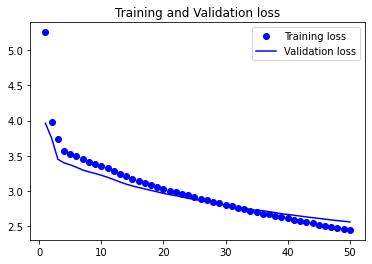

In [72]:
plt.plot(epochs , loss , 'bo' ,  label = 'Training loss')
plt.plot(epochs , val_loss , 'b' ,  label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [73]:

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
#attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
#decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [74]:
def decode_sequence_LSTM(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1,2 :]) + 2
        if(sampled_token_index == 0):
          print('sample token index',sampled_token_index)
        if(sampled_token_index == 0):
          next
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [75]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [76]:
for i in range(4,5):
    print("Review:",seq2text(x_val[i]))
    manual_summary = seq2summary(y_val[i])
    print("Original summary:",manual_summary)
    output = decode_sequence_LSTM(x_val[i].reshape(1,max_text_len))
    print("Predicted summary:",output)
    print("\n")

Review: laws bite spammer net spam king seeking bankruptcy man behind billions junk mail said lawsuits forced company chapter optinrealbig fighting several legal notably pushing millions dollars company said filing chapter would help try resolve legal problems still keep third biggest spammer world junk mail watchdog optinrealbig sued december sending mail messages violated lawsuit brought microsoft new york attorney general eliot spitzer alleged mr sent billions spam messages compromised net addresses according microsoft messages sent via net addresses owned ministries communication several korean virginia community college mr settled attorney general case july legal fight microsoft microsoft seeking millions dollars damages optinrealbig laws impose penalties every statement announcing desire seek bankruptcy protection company said could continue contend legal debts included microsoft seeking via litigation relentless distraction said steven legal counsel make expect part optinrealbig

In [77]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

In [78]:
candidate = output.strip().split()
reference=manual_summary.strip().split()

In [79]:
score = sentence_bleu([reference], candidate)
print(score)

0.6158381792412306


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [80]:
score = corpus_bleu([[reference]],[candidate])
print(score)

0.6158381792412306


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [81]:
!pip install rouge

In [82]:
from rouge import Rouge
r = Rouge()

In [83]:
scores = r.get_scores([manual_summary],[output])

In [67]:
print(scores)

[{'rouge-1': {'f': 0.1735537142217063, 'p': 0.21875, 'r': 0.14383561643835616}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.1684210491878117, 'p': 0.10810810810810811, 'r': 0.38095238095238093}}]
